In [1]:
%matplotlib inline

In [2]:
from clpsych.store import Store
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, f1_score

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [3]:
data = Store('data.h5').data
data['class'] = data['user_id'] > 0

In [4]:
train_classes = pd.DataFrame.from_csv('data/classes/train_classes.txt')
test_classes = pd.DataFrame.from_csv('data/classes/dev_classes.txt')

train_data = data.merge(train_classes, on='post_id')
test_data = data.merge(test_classes, on='post_id')

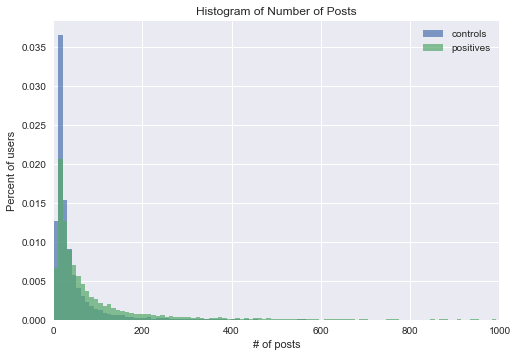

In [9]:
by_user = data.groupby('user_id')
posts = sorted([(u, len(pst)) for u, pst in by_user.groups.items()], key=lambda x: x[1], reverse=True)[100:]

positives = [v for u, v in posts if u > 0]
controls = [v for u, v in posts if u < 0]

_, bins, _ = plt.hist(controls, bins=150, alpha=0.7, label='controls', normed=True)
_, bins, _ = plt.hist(positives, alpha=0.7, bins=bins, label='positives', normed=True)

plt.legend()
plt.xlabel('# of posts')
plt.ylabel('Percent of users')
plt.title('Histogram of Number of Posts')
plt.xlim(0, 1000)

plt.savefig('post_count_histogram.png')

In [19]:
by_subreddit_group = data.groupby(['subreddit', 'class'])

positives = [(k[0], len(v)) for k, v in by_subreddit_group.groups.items() if k[1] == True]
controls = [(k[0], len(v)) for k, v in by_subreddit_group.groups.items() if k[1] == False]

total_positives = sum([v for k, v in positives])
total_controls = sum([v for k, v in controls])

dfp = pd.DataFrame(positives, columns=['subreddit', 'p_count'])
dfc = pd.DataFrame(controls, columns=['subreddit', 'c_count'])

dfp['p_count'] = dfp['p_count'].apply(lambda x: 1. * x / total_positives)
dfc['c_count'] = dfc['c_count'].apply(lambda x: 1. * x / total_controls)

merged = dfp.merge(dfc, on='subreddit', how='outer').replace(np.nan, 0)
merged['diff'] = merged['p_count'] - merged['c_count']
merged.sort_values(by='diff', ascending=[0])

,subreddit,p_count,c_count,diff
9289,FreeStuffNYC,0.029629,0.000000,0.029629
28731,politics,0.028575,0.007779,0.020796
5811,AskReddit,0.041899,0.029767,0.012132
23276,SuicideWatch,0.011862,0.000000,0.011862
20962,TrendingReddits,0.010784,0.000000,0.010784
1132,depression,0.008730,0.000000,0.008730
27872,environment,0.007317,0.000354,0.006963
12346,TrendingNSFW,0.006148,0.000000,0.006148
19591,spam,0.005080,0.000185,0.004895
23380,offbeat,0.006367,0.001477,0.004891


In [20]:
train_by_user = train_data.groupby('user_id')
test_by_user = test_data.groupby('user_id')

In [21]:
by_user = data.groupby('user_id')

users = by_user.groups.keys()
subreddits = [[s for s in by_user.get_group(u)['subreddit'].tolist() if 'suicide' not in s.lower()] for u in users]

# ensure consistency
train_users = train_by_user.groups.keys()
test_users = test_by_user.groups.keys()

train_subreddits = [[s for s in train_by_user.get_group(u)['subreddit'].tolist() if 'suicide' not in s.lower()] for u in train_users]
test_subreddits = [[s for s in test_by_user.get_group(u)['subreddit'].tolist() if 'suicide' not in s.lower()] for u in test_users]

In [22]:
vectorizer = CountVectorizer(tokenizer=lambda x: x, lowercase=False)
vectorizer.fit(train_subreddits)
X_train = vectorizer.transform(train_subreddits)
X_test = vectorizer.transform(test_subreddits)
X = vectorizer.transform(subreddits)

In [23]:
svd = TruncatedSVD(n_components=130)
train_fit = svd.fit_transform(X_train)
test_fit = svd.transform(X_test)
fit = svd.transform(X)

In [24]:
svdized = pd.DataFrame(train_fit)
svdized['user_id'] = train_users
svdized['class'] = svdized['user_id'] > 0
y_train = svdized['class'].as_matrix()

In [25]:
test_svdized = pd.DataFrame(test_fit)
test_svdized['user_id'] = test_users
test_svdized['class'] = test_svdized['user_id'] > 0
y_test = test_svdized['class'].as_matrix()

In [26]:
together_svdized = pd.DataFrame(fit)
together_svdized['user_id'] = users

In [27]:
clf = RandomForestClassifier(n_estimators=30, max_depth=10, n_jobs=3)
#clf = AdaBoostClassifier(n_estimators=100)
clf.fit(train_fit, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=30, n_jobs=3, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

Accuracy: 0.746527777778
AUC: 0.745398793816
F1: 0.725821596244


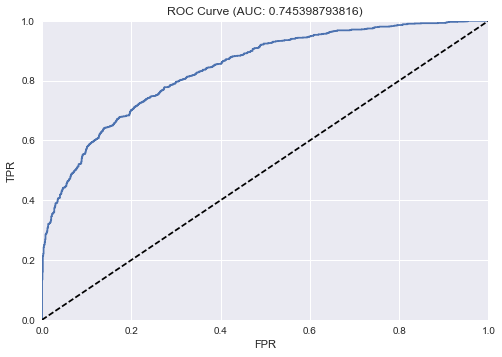

In [28]:
labels = clf.predict_proba(test_fit)

fpr, tpr, thresholds = roc_curve(y_test, labels[:, 1])
plt.title('ROC Curve (AUC: {})'.format(roc_auc_score(y_test, np.argmax(labels, axis=1))))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot(fpr, tpr)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.savefig('subreddit_roc.png')

print 'Accuracy:', accuracy_score(y_test, np.argmax(labels, axis=1))
print 'AUC:', roc_auc_score(y_test, np.argmax(labels, axis=1))
print 'F1:', f1_score(y_test, np.argmax(labels, axis=1))

In [373]:
together_svdized.to_csv('subreddits.csv')